In [9]:
import os
import numpy as np

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# %matplotlib widget
%matplotlib inline

In [10]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())

In [11]:
# del mcolors.TABLEAU_COLORS['tab:pink']
colors = list(mcolors.TABLEAU_COLORS.keys())
markers = ['o', '<', '>', 'v', 's', 'D', '*']

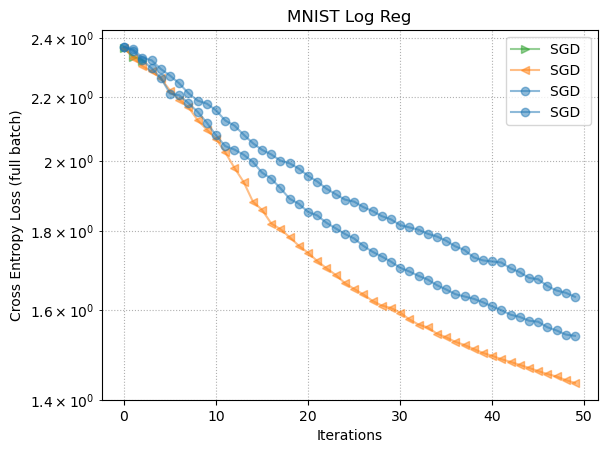

In [17]:
label_key = 'optimizer'
metric_key = 'loss'
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGD']
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

    # if config['batch_size'] != 4:
    #     continue
    title = 'MNIST Log Reg | batch_size=' + str(config['batch_size'])
    beg = 0
    end = 120000

    # label = config[label_key]['name'] + ' ' + r.data.params['Title']
    add = 0
    if config['md_full_'] is not None:
        add = int(config['md_full_'])
    i = config[label_key]['id'] + add
    history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
    y = np.array([h.value for h in history])
    x = np.array([h.timestamp for h in history])
    x = np.array([h.step for h in history])
    mask = (x >= beg)*(x <= end)
    x, y = x[mask], y[mask]

    plt.plot(x, y,
             alpha=0.5, color=colors[i],
             marker=markers[i], markevery=1,
             label=label)

    # print()
# title = '%s, bs=%i' % (an, bs)
title = 'MNIST Log Reg'
plt.title(title)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss (full batch)')
plt.yscale('log')
plt.xscale('linear')
plt.grid(True, which="both", ls='dotted')
plt.legend()
plt.savefig('figures/'+ title +'.pdf', bbox_inches='tight')
# plt.savefig(title +'.pdf', bbox_inches='tight')
plt.show()

50


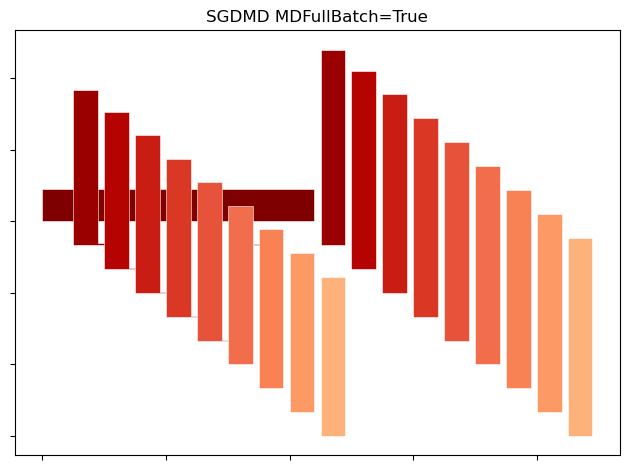

50


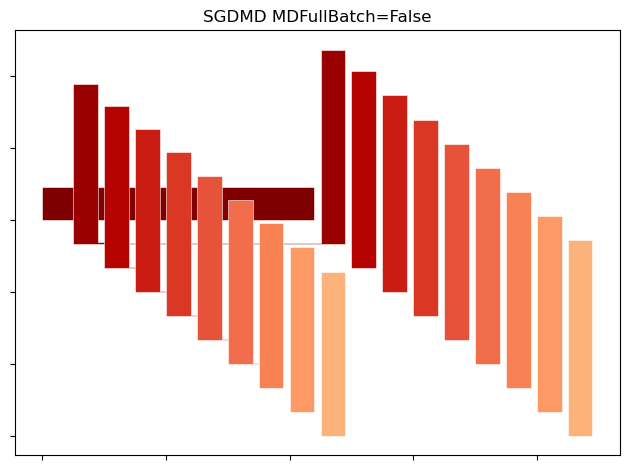

In [234]:
import numpy as np
import matplotlib.pyplot as plt


label_key = 'optimizer'
metric_key = 'weights'
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

from matplotlib import cm
colors = cm.OrRd_r(np.linspace(.0, .6, 10))

optimizer_names = ['SGD']
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

    if config[label_key]['name'] == 'SGD':
        continue

    if config['batch_size'] != 20:
        continue

    label = config[label_key]['name'] + ' ' + r.data.params['Title']
    i = config[label_key]['id'] + int(config['md_full'])
    weights = []
    for i in range(config['n_peers']):
        metric_key = 'weights_%s' % (str(i))
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.step for h in history])
        weights.append(y)
    weights = np.array(weights)
    print(len(weights.T))
    y = weights.T
    for j, i in enumerate(np.linspace(0, len(y)-1, 10, endpoint=True).round().astype(int)):
        bins, edges = y[i], np.linspace(0, len(y[i]), len(y[i])+1)

        left, right = edges[:-1], edges[1:]
        X = np.array([left, right]).T.flatten()
        Y = np.array([bins, bins]).T.flatten()

        x_shift = j * 1.25
        y_shift = -j/15
        plt.fill_between(X+x_shift, Y+y_shift, y_shift, facecolor = colors[j], linewidth=0.4, edgecolor='w')

    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    # title = 'MNIST Log Reg'
    title = 'MNIST Log Reg | batch_size=' + str(config['batch_size'])
    title = config[label_key]['name'] + ' ' + r.data.params['Title']
    plt.title(title)
    plt.tight_layout()
    plt.show() 
    # break


